# Progetto di Social Computing

a.a. 2022/2023

## Attività preliminari

### Librerie e costanti

In [1]:
# Import delle librerie utilizzate
import os, tweepy, json
import networkx as nx 
import pandas as pd 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
from pyvis.network import Network
from pylab import rcParams


In [2]:
# Cartelle di salvataggio
data_folder = "./data"
out_folder = "./out"
graph_folder = "./graphs"

### Funzioni

In [3]:
# Salvataggio in locale
def serialize_json(folder, filename, data):
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)
    
    with open(f"{folder}/{filename}", "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent = 4)
        f.close()
    print(f"Data serialized to path: {folder}/{filename}")

In [4]:
# Lettura da locale
def read_json(path):
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as file:
            data = json.load(file)
        print(f"Data read from path: {path}")
        return data
    else:
        print(f"No data found at path: {path}")
        return {}

### Credenziali Twitter API

In [6]:
# Caricamento credenziali da JSON
api_access = read_json("./api_access.json")

Data read from path: ./api_access.json


## Recupero dei follower e dei follower dei follower

### Recupero dei follower

Si vogliono recuperare, utilizzando la libreria `tweepy`, tutti i follower dell'utente *@KevinRoitero*, corredati delle seguenti informazioni:

* attributi di default;
* descrizione del profilo;
* metriche pubbliche dell'account;
* se l'account è protetto

In [18]:
 # Si inizializza il client
client = tweepy.Client(bearer_token=api_access["bearer_token"])

username = "KevinRoitero"
all_user_followers = []

# Si recuperano e memorizzano le informazioni dell'utente
response = client.get_user(username = username, user_fields=["description", "protected", "public_metrics"])
user = dict(response.data)

# Si recuperano e memorizzano i follower dell'utente
response = client.get_users_followers(user["id"], user_fields=["description", "protected", "public_metrics"], 
                                      max_results=150) # max_results = 150 perché i follower dell'utente sono nell'ordine di 130
for follower in response.data:
    all_user_followers.append(dict(follower))

# Si associano i follower trovati all'utente di partenza
user["followers"] = all_user_followers

# Si serializza su JSON il risultato ottenuto
serialize_json(data_folder, "user_followers.json", user)

Data serialized to path: ./data/user_followers.json


### Aggiunta del numero di tweet prodotti nell'ultima settimana

Ai follower trovati, si vuole aggiungere il numero di tweet pubblicati nell'ultima settimana. Per avere uniformità, troveremo anche il numero di tweet pubblicati nell'ultima settimana dall'utente *@KevinRoitero*.

In [6]:
# Somma dei numeri di tweet prodotti in un intervallo di tempo
def sum_tweets_count(tweet_groups):
    sum = 0

    for tweet_count in tweet_groups:
        sum += tweet_count["tweet_count"]
    
    return sum

In [19]:
# Si sceglie l'utilizzo dello stesso client di partenza, o comunque senza la possibilità di mettersi in attesa, 
# perché numero_richieste < 300, dove 300 è il numero massimo di richieste per l'endpoint get_recent_tweets_count()
client = tweepy.Client(bearer_token=api_access["bearer_token"])

# Si caricano i dati dell'utente e quelli dei suoi follower
user = read_json(data_folder+"/user_followers.json")

# Si memorizza il numero di tweet pubblicati dall'utente nell'ultima settimana
response = client.get_recent_tweets_count(query="from:"+user["username"], granularity="day")
user["last_week_tweets_count"] = sum_tweets_count(response.data)

# Si ripete lo stesso per i follower dell'utente
for follower in user["followers"]:
    if(not follower["protected"]): # non si può accedere ai tweet di un utente 'protected'
        response = client.get_recent_tweets_count(query="from:"+follower["username"], granularity="day")
        follower["last_week_tweets_count"] = sum_tweets_count(response.data)

# Si serializza su JSON il risultato ottenuto
serialize_json(data_folder, "followers_last_week_tweets.json", user)

Data read from path: ./data/user_followers.json
Data serialized to path: ./data/followers_last_week_tweets.json


### Recupero dei follower dei follower

Per ciascun follower di *@KevinRoitero* avente almeno 1 follower e non `protected`, si vogliono scaricare le seguenti informazioni:

* attributi di default;
* descrizione del profilo;
* metriche pubbliche dell'account;
* se l'account è protetto

L'approccio che è stato seguito è quello di un download *parallelo*, ossia ciascun collaboratore al progetto si è preso in carico di scaricare una porzione di follower dei follower di *@KevinRoitero*.

In [7]:
# Si impone al client di attendere nel caso di raggiungimento del limite delle richieste
client = tweepy.Client(bearer_token=api_access["bearer_token"], wait_on_rate_limit=True)

# Si caricano i dati dell'utente e quelli dei suoi follower
user = read_json(data_folder+"/followers_last_week_tweets.json")

# Parallelizzando il calcolo, si decide di partizionare tra collaboratori il numero di follower
all_followers = np.array(user["followers"])

f_num = user["public_metrics"]["followers_count"]
start = f_num*api_access["id"] // 4
end = f_num*(api_access["id"]+1) // 4

# Si vogliono memorizzare solamente i follower di responsabilità del collaboratore
interval_followers = []

# Si scaricano i follower dei follower nell'intervallo del collaboratore
for i in range(start, end):
    # Si considera l'i-esimo follower
    follower = all_followers[i]

    # Se l'i-esimo follower non è protetto e ha dei follower, li scarico
    if (not follower["protected"] and follower["public_metrics"]["followers_count"] > 0):
        for all_follower_followers in tweepy.Paginator(client.get_users_followers, id = follower["id"],
                                                       user_fields=["description", "protected", "public_metrics"], max_results = 1000):
            parsed_followers = []
            
            for ff in all_follower_followers.data:
                # L'oggetto User deve essere interpretato
                parsed_follower = {
                    "id" : ff["id"],
                    "public_metrics" : ff["public_metrics"],
                    "description" : ff["description"],
                    "name" : ff["name"],
                    "protected" : ff["protected"],
                    "username" : ff["username"]
                }
                parsed_followers.append(parsed_follower)
            
            follower["followers"] += parsed_followers
    
    # Aggiungo il follower (arricchito dei suoi follower) nella lista di follower di competenza del collaboratore
    interval_followers.append(follower)

# Si salva la porzione di follower scaricata
serialize_json(data_folder, "f_of_f_"+str(api_access["id"])+".json", list(interval_followers))

Data read from path: ./data/followers_last_week_tweets.json


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 891 seconds.


Data serialized to path: ./data/f_of_f_2


Si uniscono ora i file generati dai diversi collaboratori in un unico file JSON.

In [15]:
# Si carica il JSON con le informazioni su @KevinRoitero
user = read_json(data_folder+"/followers_last_week_tweets.json")
followers = []

for i in range(0, 4):
    # Si caricano i follower individuati dal collaboratore i
    partial_followers = read_json(data_folder+"/f_of_f_"+str(i)+".json")
    
    # Si concatenano all'elenco completo dei follower
    followers += partial_followers

# Si aggiornano i dati sui follower di @KevinRoitero
user["followers"] = followers

# Si serializza il risultato ottenuto
serialize_json(data_folder, "user_complete.json", user)

Data read from path: ./data/followers_last_week_tweets.json
Data read from path: ./data/f_of_f_0.json
Data read from path: ./data/f_of_f_1.json
Data read from path: ./data/f_of_f_2.json
Data read from path: ./data/f_of_f_3.json
Data serialized to path: ./data/user_complete.json


### Riformattazione del JSON finale

Al fine di essere conformi alle specifiche della consegna, si decide di ristrutturare (ossia modificarne la presentazione, pur mantenendo invariate le informazioni al suo interno) il JSON `user_complete.json` definito in precedenza.

Il formato che è stato ritenuto come più opportuno, sia per un'efficienza di archiviazione che di computazione (importante per le sezione successive), è il seguente:
```json
{
    ...
    id (int) : {
        "name" : str,
        "username" : str,
        "description" : int,
        "public_metrics" : {
            "followers_count" : int,
            "following_count" : int,
            "tweet_count" : int,
            "listed_count" : int
        },
        "protected" : bool,
        ("last_week_tweets_count" :int,)
        ("followers" : [
            ...
            f_id (int),
            ...
        ])
    }
    ...
}
```

Dove `id` rappresenta l'identificativo univoco di un utente, le cui informazioni sono state scaricate nei passi precedenti, ed `f_id` rappresenta l'identificativo di un follower di `id`.

È doveroso far notare che, per come sono stati scaricati gli utenti, solamente coloro che o sono *@KevinRoitero* o sono suoi follower (non `protected`) presentano il campo `last_week_tweets_count` ed il campo `followers` (da cui le parentesi tonde nello schema).

In [21]:
# Si definisce una funzione che esegue una normalizzazione di un singolo utente
def normalize_into(user, root_distance, destination):
    # Si normalizza l'utente considerato
    normalized = {
        "name" : user["name"],
        "username" : user["username"],
        "description" : user["description"],
        "public_metrics" : user["public_metrics"],
        "protected" : user["protected"]
    }

    # Se user non è un follower dei follower e non è protetto, si possono definire i dettagli aggiuntivi
    if (root_distance < 2 and not user["protected"]):
        # Si estraggono le ids dei follower dell'utente
        f_ids = []
        for f in user["followers"]:
            f_ids.append(f["id"])

        normalized["last_week_tweets_count"] = user["last_week_tweets_count"]
        normalized["followers"] = f_ids
    
    # Se l'utente non è già definito in 'destination', lo si aggiunge
    if user["id"] not in destination:
        destination[user["id"]] = normalized

In [22]:
# Si carica il JSON completo, non formattato
root_user = read_json(data_folder+"/user_complete.json")

nodes = {} # JSON finale

normalize_into(user = root_user, root_distance=0, destination = nodes)

# Si fa la stessa cosa per follower di @KevinRoitero
for follower in root_user["followers"]:
    normalize_into(user = follower, root_distance = 1, destination = nodes)

# ... e per i follower dei follower
for follower in root_user["followers"]:
    if (not follower["protected"]):
        for ff in follower["followers"]:
            normalize_into(user = ff, root_distance = 2, destination = nodes)

# Si serializza il JSON ben formattato
serialize_json(data_folder, "users_final.json", nodes)

Data read from path: ./data/user_complete.json
Data serialized to path: ./data/users_final.json


Si consideri che, per come è stato costruito, il file `users_final.json` presenta una struttura ordinata:

1. Al primo posto vi sonoi dettagli sul profilo di *@KevinRoitero*;
2. dal secondo posto fino al 134-esimo vi sono i follower di *@KevinRoitero*;
3. dal 135-esimo posto in poi vi sono i follower dei follower di *@KevinRoitero*.

## Generazione dei grafi

### Generazione del grafo della rete sociale diretta

Si vuole generare un grafo che abbia come nodi *@KevinRoitero* ed i suoi follower, ognuno di questi deve rispettare le seguenti caratteristiche:

* il suo `id` deve essere uguale all'`id` del profilo utente;
* deve avere come attributi:
    * lo username;
    * la descrizione;
    * il numero di follower del profilo.

Infine, si vogliono aggiungere archi $(v,w)$ tra due nodi $v$ e $w$ se e solo se il profilo corrispondente a $v$ è follower del profilo corrispondente a $w$.

In [39]:
# Si crea un grafo diretto vuoto
social_graph = nx.DiGraph()

# Si considera l'insieme dei profili utente
users = read_json(data_folder+"/users_final.json")

# La struttura del file permette di fare un inserimento "ordinato"
added = 0
for id in users:
    user = users[id]
    social_graph.add_node(
        int(id),
        username = user["username"], 
        description = user["description"],
        followers_count = user["public_metrics"]["followers_count"]
    )
    
    added += 1
    # Il 134-esimo utente è l'ultimo follower di @KevinRoitero
    if(added == 134):
        break

# N.B.: questo trucchetto dell'inserimento ordinato è possibile solamente grazie al fatto che la funzione read_json() ed il costrutto for,
#       rispettivamente, caricano in memoria principale le informazioni in ordine di apparizione ed iterano su di esse rispettando ancora
#       il loro ordine di apparizione. Se questi dettagli implementativi dovessero cambiare, sarebbe necessario apportare modifiche anche
#       a questa soluzione.

# Si aggiungono gli archi tra i nodi
for v in social_graph.nodes:
    for w in social_graph.nodes:
        if (not v == w and not users[str(w)]["protected"] and v in users[str(w)]["followers"]):
            social_graph.add_edge(v, w)

# Si serializza il grafo finale
serialize_json(graph_folder, "social_graph.json", nx.node_link_data(social_graph))

Data read from path: ./data/users_final.json
Data serialized to path: ./graphs/social_graph.json


### Generazione grafo con preferential attachment 

Si genera un secondo grafo a partire da quello definito in precedenza, nel seguente modo:

1. si converte `social_graph` in grafo indiretto;
2. a tale grafo indiretto si aggiungono dei nodi, utilizzando il metodo del preferential attachment, tali che:
    - il numero di nodi aggiunti è uguale al numero di nodi già presenti nel grafo;
    - ogni nodo aggiunto ha due archi uscenti.

In [40]:
# Si importa il grafo definito in precedenza
social_graph = nx.node_link_graph(read_json(graph_folder+"/social_graph.json"))

# Si crea il grafo indiretto intermedio
number_of_nodes = social_graph.number_of_nodes()
undirected_graph = social_graph.to_undirected()

# Si aggiungono i nodi utilizzando il preferential attachment
preferential_graph = nx.barabasi_albert_graph(number_of_nodes*2, 2, initial_graph = undirected_graph)

# Serializzazione del grafo
serialize_json(graph_folder, "preferential_graph.json", nx.node_link_data(preferential_graph))

Data read from path: ./graphs/social_graph.json
Data serialized to path: ./graphs/preferential_graph.json


## Analisi dei grafi

In [8]:
# Si definiscono una tantum i parametri delle figure in output
rcParams['figure.figsize'] = 12, 12

### Visualizzazione dei grafi attraverso nodi di dimensione variabile

Si vogliono disegnare i due grafi definiti nelle sezioni precedenti in modo che la dimensione dei nodi raffigurati sia direttamente proporzionale:

- all'in-degree (grado in entrata) per il grafo diretto
- al degree (grado) per il grafo indiretto

 Si userà l'algoritmo di [Fruchterman-Reingold](https://github.com/gephi/gephi/wiki/Fruchterman-Reingold) per la distribuzione dei noid.

In [29]:
# Si definisce una funzione per disegnare un grafo in cui la dimensione dei nodi è direttamente proporzionale all'(in-)degree
def plot_graph(graph, graph_name):
    node_size = []
    k = 5 # costante di "ingrandimento" dei nodi
    # A seconda della natura del grafo, si sceglie quale metrica usare
    if nx.is_directed(graph):
        for node in graph.nodes():
            node_size.append(graph.in_degree(node)*k)
    else:
        for node in graph.nodes():
            node_size.append(graph.degree(node)*k)

    # Si disegna il grafo
    nx.draw_networkx(
        graph, 
        pos = nx.spring_layout(graph), # algoritmo di Fruchterman-Reingold
        node_color = '#A0CBE2',
        edge_color = (0,0,0,0.3), # gli archi sono trasparenti al fine di far risaltare i nodi
        with_labels = False,
        node_size = node_size
    )
    
    plt.savefig(out_folder + "/"+graph_name+".pdf")
    plt.show()

Data read from path: ./graphs/social_graph.json


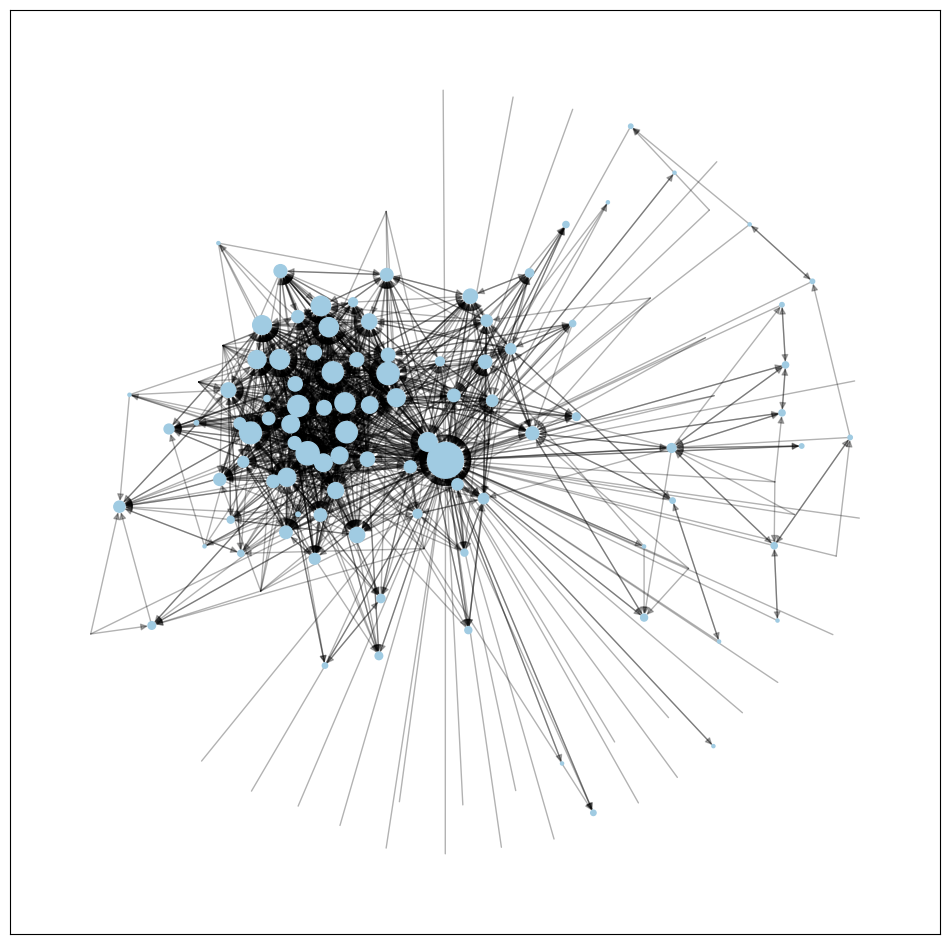

In [30]:
# Si visualizza il grafo diretto
social_graph = nx.node_link_graph(read_json(graph_folder+"/social_graph.json"))
plot_graph(social_graph, "social_graph")

Data read from path: ./graphs/preferential_graph.json


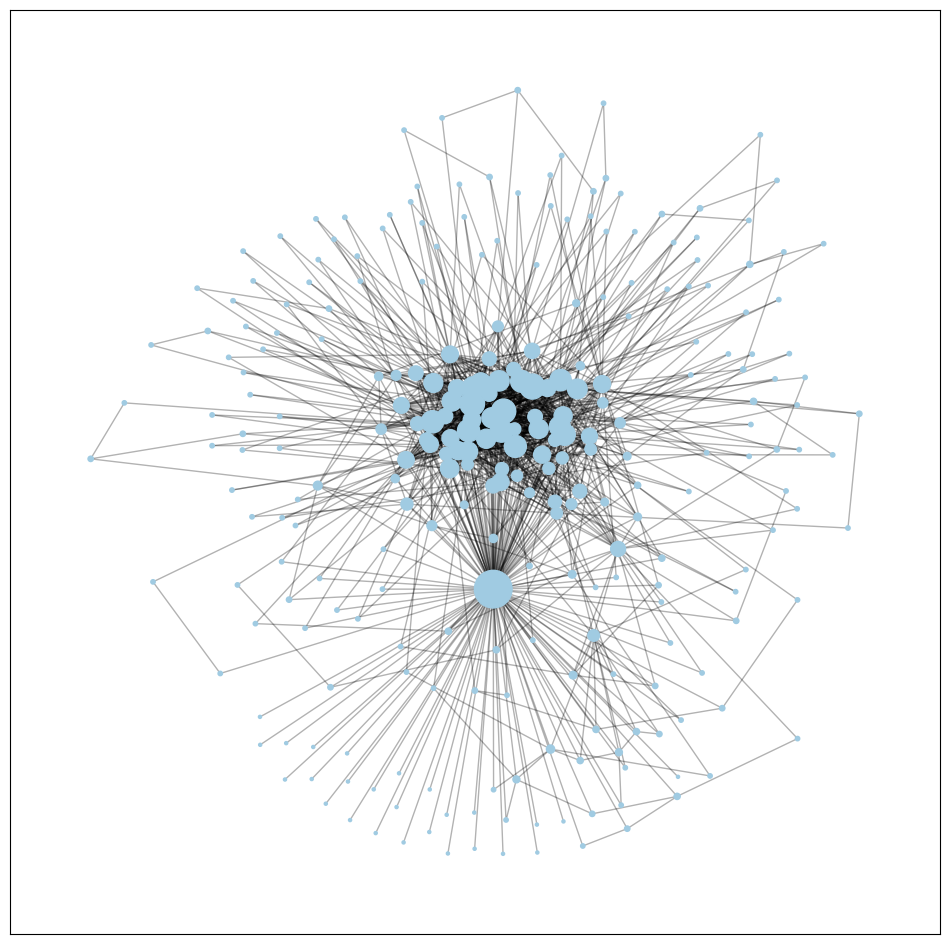

In [28]:
preferential_graph = nx.node_link_graph(read_json(graph_folder+"/preferential_graph.json"))
plot_graph(preferential_graph, "preferential_graph")

### Visualizzazione della più grande componente fortemente connessa

Per ciascuno dei due grafi, si produce una visualizzazione statica del grafo con una colorazione rossa dei nodi appartenenti alla più grande componente fortemente connessa (SCC), nera per gli altri.

In [43]:
def highlight_largest_SCC(graph, graph_name):
    # identifico i nodi appartenenti alla SCC più grande
    largest = []
    if nx.is_directed(graph):
        largest = max(nx.strongly_connected_components(graph), key=len)
    else:
        largest = max(nx.connected_components(graph), key=len)
    # salvo i nodi appartenenti alla scc
    scc = nx.subgraph(graph, largest)

    # si mappa a ciascun nodo il colore appropriato
    color_map=[]
    for node in graph:
        if node in largest:
            #se il nodo fa parte della SCC più grande viene colorato di rosso
            color_map.append('red')
        else:
            #altrimenti di nero
            color_map.append('black')

    # si disegna il grafo con la mappatura definita
    nx.draw_networkx(
        graph,
        pos = nx.spring_layout(graph),
        node_color = color_map,
        edge_color = (0,0,0,0.3),
        with_labels = False
    )
    
    # si salva il grafo e si restituisce il sottografo con i nodi appartenenti alla più grande SCC
    plt.savefig(out_folder+"/"+graph_name+"_SCC.pdf")
    return scc

Data read from path: ./graphs/social_graph.json
Data serialized to path: ./graphs/social_scc.json


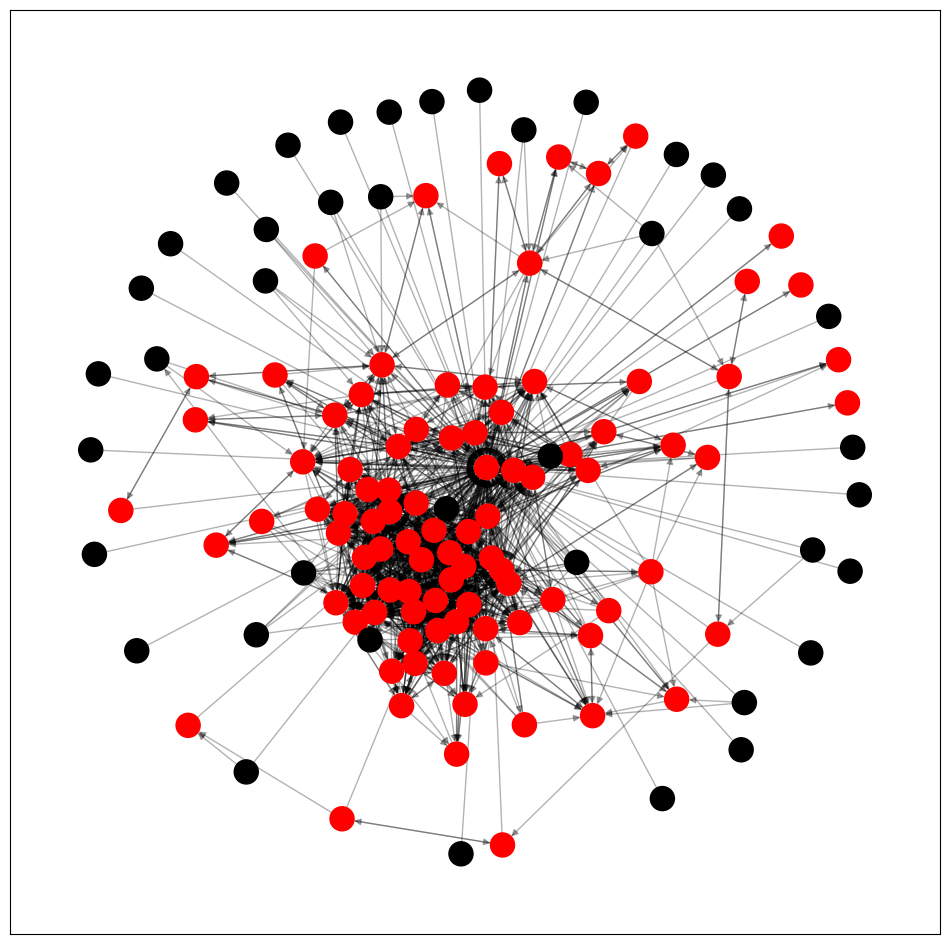

In [44]:
# Si evidenzia la SCC più grande per il grafo diretto
social_graph = nx.node_link_graph(read_json(graph_folder+"/social_graph.json"))

# Serializzazione del sotto-grafo con la più grande SCC
social_scc = highlight_largest_SCC(social_graph, "social_graph")
serialize_json(graph_folder, "social_scc.json", nx.node_link_data(social_scc))

Data read from path: ./graphs/preferential_graph.json


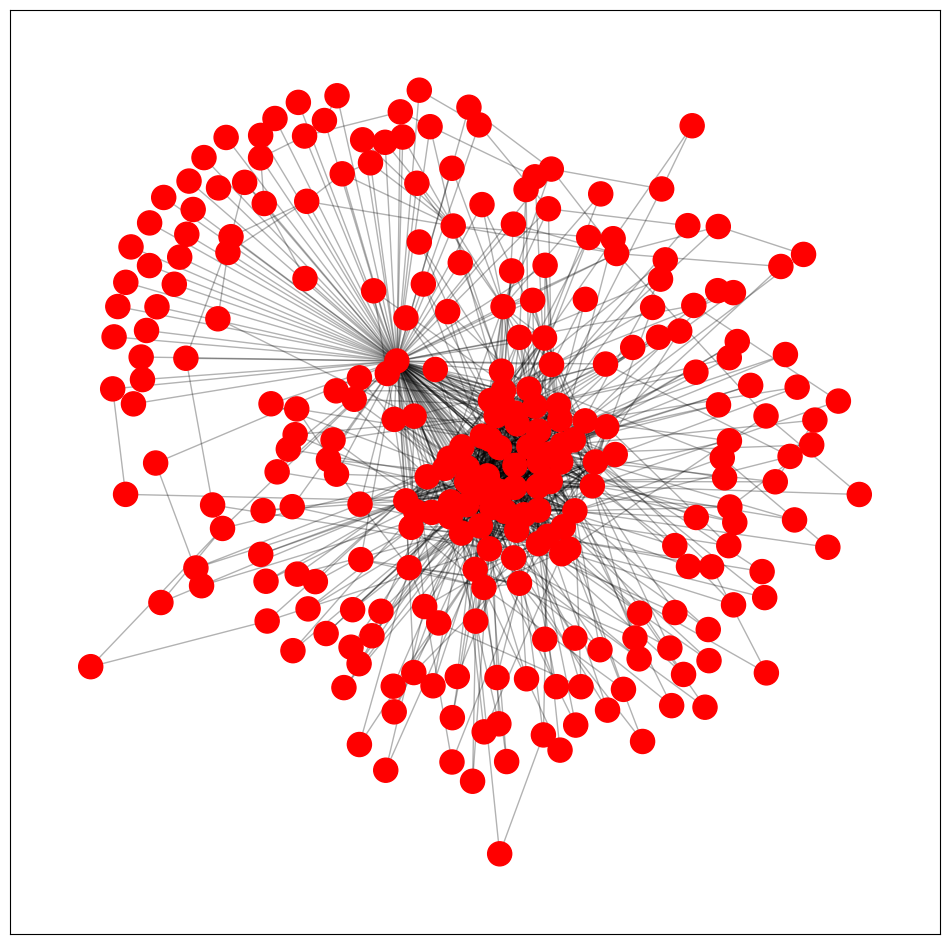

In [45]:
# Si evidenzia la più grande SCC per il grafo indiretto
preferential_graph = nx.node_link_graph(read_json(graph_folder+"/preferential_graph.json"))
highlight_largest_SCC(preferential_graph, "preferential_graph")

### Distanze

Si calcoleranno le seguenti distanze sui due grafi:

- il centro;
- il raggio;
- la distanza media;
- la distanza massima.

In [46]:
# Si importano i grafi rilevanti
preferential_graph = nx.node_link_graph(read_json(graph_folder+"/preferential_graph.json"))
social_graph = nx.node_link_graph(read_json(graph_folder+"/social_graph.json"))
social_scc = nx.node_link_graph(read_json(graph_folder+"/social_scc.json"))

# si prepara un dizionario delle distanze
distances = {}

#centro
distances["center"] = [list(nx.center(social_scc)), list(nx.center(preferential_graph))]
#raggio
distances["radius"] = [nx.radius(social_scc), nx.radius(preferential_graph)]
#distanza media
distances["avarage_distance"] = [nx.average_shortest_path_length(social_graph), nx.average_shortest_path_length(preferential_graph)]
#distanza massima 
distances["max_distance"] = [nx.diameter(social_scc, usebounds=True), nx.diameter(preferential_graph, usebounds=True)]

# si visualizzano le distanze attraverso una tabella
pd.DataFrame(distances, index=["social_graph", "preferential_graph"])

Data read from path: ./graphs/preferential_graph.json
Data read from path: ./graphs/social_graph.json
Data read from path: ./graphs/social_scc.json


,center,radius,avarage_distance,max_distance
social_graph,"[3051698888, 1734817550, 3037264899, 2827812417]",4,1.530917,7
preferential_graph,[3036907250],2,2.552295,4


### Calcolo delle misure di centralità

Si vogliono calcolare le seguenti metriche inerenti alla centralità dei due grafi:
- centralità di betweenness;
- centralità di prossimità;
- centralità di grado (in entrata/uscita);
- PageRank;
- HITS.

In [48]:
# Si definisce una funzione per restituire la lista di valori di un dizionario
def to_list(dict):
    return list(dict.values())

# Si definisce una funzione che compone un dizionario con le metriche di centralità rilevanti
def compute_centrality_metrics(graph):
    metrics = {}
    # Betweenness
    metrics["betweenness"] = to_list(nx.betweenness_centrality(graph))
    # Closeness
    metrics["closeness"] = to_list(nx.closeness_centrality(graph))
    # (in/out-)degree
    if(nx.is_directed(graph)):
        metrics["in_degree"] = to_list(nx.in_degree_centrality(graph))
        metrics["out_degree"] = to_list(nx.out_degree_centrality(graph))
    else:
        metrics["degree"] = to_list(nx.degree_centrality(graph))
    # PageRank
    metrics["pagerank"] = to_list(nx.pagerank(graph))
    # HITS
    metrics["hits"] = to_list(nx.hits(graph)[0])

    return metrics

In [49]:
# si importano i due grafi
preferential_graph = nx.node_link_graph(read_json(graph_folder+"/preferential_graph.json"))
social_graph = nx.node_link_graph(read_json(graph_folder+"/social_graph.json"))

# si calcolano le metriche di centralità per i due grafi
sg_centrality = compute_centrality_metrics(social_graph)
pg_centrality = compute_centrality_metrics(preferential_graph)

# si mostrano le metriche calcolate sotto forma di tabella
display(pd.DataFrame(sg_centrality, index=social_graph.nodes()))
display(pd.DataFrame(pg_centrality, index=preferential_graph.nodes()))

Data read from path: ./graphs/preferential_graph.json
Data read from path: ./graphs/social_graph.json


c:\Users\stefa\anaconda3\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


,betweenness,closeness,in_degree,out_degree,pagerank,hits
3036907250,0.426283,1.000000,1.000000,0.518797,0.092158,0.027026
2582519183,0.007576,0.354667,0.022556,0.030075,0.002999,0.001661
1558731210570010624,0.000000,0.262327,0.007519,0.015038,0.001757,0.001297
998681467696885761,0.002310,0.540650,0.150376,0.233083,0.011129,0.020021
1176475874759270400,0.000000,0.000000,0.000000,0.030075,0.001119,0.003844
...,...,...,...,...,...,...
569382995,0.000000,0.000000,0.000000,0.030075,0.001119,0.001382
51023058,0.000066,0.509579,0.037594,0.015038,0.004663,0.001484
2827812417,0.022386,0.258755,0.015038,0.022556,0.002340,0.001289
1556357336,0.048882,0.515504,0.060150,0.075188,0.008115,0.002764


,betweenness,closeness,degree,pagerank,hits
3036907250,0.462894,0.686375,0.543071,0.065879,0.027045
2582519183,0.001635,0.412037,0.018727,0.002705,0.001211
1558731210570010624,0.000023,0.409509,0.011236,0.002057,0.000892
998681467696885761,0.026460,0.506641,0.134831,0.011510,0.015380
1176475874759270400,0.000000,0.419152,0.014981,0.001742,0.002598
...,...,...,...,...,...
263,0.000084,0.342308,0.007491,0.001454,0.000502
264,0.000011,0.326406,0.007491,0.001191,0.000404
265,0.000000,0.356475,0.007491,0.001117,0.001045
266,0.000051,0.334586,0.007491,0.001190,0.000479


### Coefficenti per la stima della "small-worldness" 

I coefficienti per la "small-worldness" del grafo indiretto sono:

- il coefficiente omega;
- il coefficiente sigma.

In [ ]:
preferential_graph = nx.node_link_graph(read_json(graph_folder+"/preferential_graph.json"))

# si calcolano i valori
omega_value = nx.omega(preferential_graph)
sigma_value = nx.sigma(preferential_graph)

print(f"Coefficiente omega: {omega_value}\nCoefficiente sigma: {sigma_value}")